# Data Collection and Cleaning

Data has been collected from both the EPA for Air Quality Index data and from the CDC for birth data relating to weight.  

## Imports

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

## Data

### EPA AQI Data

Data is in individual CSV files that need to be read in and concatenated

In [465]:
data_path = Path('data/')

# create a list of all the AQI csv files
aqs_dfs = [
    pd.read_csv(file) for file in data_path.glob('AQS_county*') if file.is_file()
]

# concatenate the dataframes
aqs = pd.concat(aqs_dfs)

#### Important note: use validity indicator to drop unusable rows

After spending time with the data dictionary and other various resources from AirData on the aspects of the data we were collecting we decided to filter out certain values.  So here we only want data that has been indicated as valid.

In [466]:
aqs = aqs[aqs['validity_indicator']=='Y']

In [467]:
aqs.shape

(78089, 57)

#### Borrow EPA standard and only take measurements where `valid_day_count` > 75% of days in year

The EPA generally uses 75% as the cutoff for aggregation measures, so we will follow that here.
* [Source](https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html#data-aggregation-summarization)

In [468]:
.75*365

273.75

In [469]:
aqs = aqs[aqs['valid_day_count'] > .75*365]

In [470]:
aqs.shape

(37855, 57)

#### Columns to Drop

As we went through the various stages of looking at all the data that was coming from the API collection, and considering what parameters and data we were focusing on for this project, we collected a list of the columns from the data to drop:

In [471]:
drop = ['state_code',
 'county_code',
 'site_number',
 'parameter_code',
 'poc',
 'latitude',
 'longitude',
 'city', 'cbsa_code', 'cbsa', 'date_of_last_change',
 'first_max_value',
  'first_max_datetime',
  'second_max_value',
  'second_max_datetime',
  'third_max_value',
  'third_max_datetime',
  'fourth_max_value',
  'fourth_max_datetime',
  'first_max_nonoverlap_value',
  'first_max_n_o_datetime',
  'second_max_nonoverlap_value',
  'second_max_n_o_datetime',
  'ninety_ninth_percentile',
  'ninety_eighth_percentile',
  'ninety_fifth_percentile',
  'ninetieth_percentile',
  'seventy_fifth_percentile',
  'fiftieth_percentile',
  'tenth_percentile',
  'local_site_name',
  'site_address',
 'datum',
 'units_of_measure',
 'sample_duration',
 'secondary_exceedance_count',
 'pollutant_standard',
 'metric_used',
 'method',
 'event_type',
 'observation_count',
 'observation_percent',
 'required_day_count',
 'exceptional_data_count',
 'null_observation_count']

In [472]:
aqs.drop(columns=drop, inplace=True)

In [473]:
aqs.head()

,parameter,sample_duration_code,year,validity_indicator,valid_day_count,primary_exceedance_count,certification_indicator,arithmetic_mean,standard_deviation,state,county,Unnamed: 0
0,Carbon monoxide,1,2006,Y,357,0.0,Certified,0.606517,0.325145,Indiana,Allen,NaN
1,Carbon monoxide,Z,2006,Y,357,0.0,Certified,0.610952,0.299519,Indiana,Allen,NaN
54,Sulfur dioxide,1,2006,Y,342,NaN,Uncertified (past due),6.141494,12.101983,Indiana,Daviess,NaN
55,Sulfur dioxide,1,2006,Y,342,27.0,Uncertified (past due),23.324561,30.901080,Indiana,Daviess,NaN
56,Sulfur dioxide,X,2006,Y,342,0.0,Uncertified (past due),6.179240,6.938465,Indiana,Daviess,NaN


In [474]:
aqs.columns

Index(['parameter', 'sample_duration_code', 'year', 'validity_indicator',
       'valid_day_count', 'primary_exceedance_count',
       'certification_indicator', 'arithmetic_mean', 'standard_deviation',
       'state', 'county', 'Unnamed: 0'],
      dtype='object')

#### Check County and State Information

Mainly looking for outliers or any text in the names that might be cause for further investigation, especially since we will be merging this data with the CDC data based on year, state, and county.

In [475]:
# aqs['county'].unique()

In [476]:
aqs['state'].unique()

array(['Indiana', 'Arkansas', 'Alabama', 'Alaska', 'Arizona',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

May want to drop locations such as:
* Puerto Rico

#### Transform Data

The data came in as individual rows, but we need to transform/reshape the data so that the AQI pollutants are columns and the values match with the year/state/county they are reported in so that we can have a complete dataset for modeling.

In [477]:
county_aqs = aqs.groupby(['state', 'county', 'year', 'parameter'])['arithmetic_mean'].mean().unstack().reset_index()

In [478]:
county_aqs.head(20)

parameter,state,county,year,Carbon monoxide,Lead (TSP) LC,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,Sulfur dioxide
0,Alabama,Colbert,2006,NaN,NaN,NaN,NaN,NaN,NaN,3.467840
1,Alabama,Colbert,2010,NaN,NaN,NaN,NaN,NaN,11.107902,NaN
2,Alabama,Etowah,2008,NaN,NaN,NaN,NaN,NaN,12.375394,NaN
3,Alabama,Etowah,2009,NaN,NaN,NaN,NaN,NaN,10.200000,NaN
4,Alabama,Etowah,2010,NaN,NaN,NaN,NaN,NaN,14.086238,NaN
5,Alabama,Houston,2010,NaN,NaN,NaN,NaN,NaN,12.826765,NaN
6,Alabama,Jackson,2006,NaN,NaN,NaN,NaN,NaN,NaN,4.273782
7,Alabama,Jefferson,2006,0.731167,NaN,NaN,NaN,34.578422,18.233563,4.851470
8,Alabama,Jefferson,2007,0.623493,NaN,NaN,NaN,38.069028,17.421237,5.019928
9,Alabama,Jefferson,2008,0.640578,NaN,NaN,NaN,30.835490,14.951876,4.779135


# QUESTIONS
* Should we impute data or how should we deal with NaNs?
    * Should we filter on counties that have all the readings?
* Do we need to try and get the other data into this format?  Like 'valid_day_count', 'primary_exceedance_count' or standard deviation
* Rename the columns now so they are easier to reference later on
* Drop the parameter index column

### CDC Data

Want to import the CDC data and compare the counties.

We are using the WONDER tool from the CDC to export the files that we are importing to this notebook. For both files, we filtered out any births with maternal risk factors so we they are not influencing birth weight.  There are some years that have no or suppressed data, which are omitted from the CDC export and are not present.We filtered out any births with maternal risk factors so we they are not influencing birth weight.  There are some years that have no or suppressed data, which are omitted from the CDC export and are not present. 

There are two main files:
1. `Natality_low_2007-2021` which represents all the births below 2500 grams by year and county. 
1. `Natality_all_2007-2021` which represents all the births by year and county.

#### Import Data

In [479]:
cdc_low = pd.read_csv('data/Natality_low_2007-2021.txt', sep='\t')
cdc_all = pd.read_csv('data/Natality_all_2007-2021.txt', sep='\t')

#### General Look and Cleanup

In [480]:
cdc_low.head()

,Notes,State,State Code,County,County Code,Year,Year Code,Births,Average Birth Weight,Average LMP Gestational Age,Average OE Gestational Age
0,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2014.0,2014.0,137.0,1995.255,34.241,34.051
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2015.0,2015.0,141.0,1832.837,32.965,32.922
2,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2016.0,2016.0,120.0,2008.358,34.467,34.058
3,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2017.0,2017.0,100.0,2082.830,34.550,34.380
4,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2018.0,2018.0,122.0,1942.303,33.762,33.508


In [481]:
cdc_all.head()

,Notes,State,State Code,County,County Code,Year,Year Code,Births,Average Birth Weight,Average LMP Gestational Age,Average OE Gestational Age
0,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2014.0,2014.0,1724.0,3296.472,38.595,38.489
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2015.0,2015.0,1857.0,3290.811,38.487,38.347
2,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2016.0,2016.0,1722.0,3315.387,38.690,38.497
3,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2017.0,2017.0,1782.0,3346.588,38.713,38.572
4,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,2018.0,2018.0,1770.0,3301.324,38.580,38.423


In [482]:
cdc_low.dtypes

Notes                           object
State                           object
State Code                     float64
County                          object
County Code                    float64
Year                           float64
Year Code                      float64
Births                         float64
Average Birth Weight           float64
Average LMP Gestational Age    float64
Average OE Gestational Age     float64
dtype: object

In [483]:
cdc_all.dtypes

Notes                           object
State                           object
State Code                     float64
County                          object
County Code                    float64
Year                           float64
Year Code                      float64
Births                         float64
Average Birth Weight           float64
Average LMP Gestational Age    float64
Average OE Gestational Age     float64
dtype: object

In [484]:
cdc_low.shape

(6712, 11)

In [485]:
cdc_all.shape

(6715, 11)

In [486]:
cdc_low.columns, cdc_all.columns

(Index(['Notes', 'State', 'State Code', 'County', 'County Code', 'Year',
        'Year Code', 'Births', 'Average Birth Weight',
        'Average LMP Gestational Age', 'Average OE Gestational Age'],
       dtype='object'),
 Index(['Notes', 'State', 'State Code', 'County', 'County Code', 'Year',
        'Year Code', 'Births', 'Average Birth Weight',
        'Average LMP Gestational Age', 'Average OE Gestational Age'],
       dtype='object'))

In [487]:
cdc_low.columns = [col.lower().replace(' ', '_') for col in cdc_low.columns]
cdc_all.columns = [col.lower().replace(' ', '_') for col in cdc_all.columns]

Renaming the % of births column, and if we want different names for other columns, we can do it at this step

In [488]:
cdc_low.columns

Index(['notes', 'state', 'state_code', 'county', 'county_code', 'year',
       'year_code', 'births', 'average_birth_weight',
       'average_lmp_gestational_age', 'average_oe_gestational_age'],
      dtype='object')

In [489]:
cdc_low['notes'].nunique(), cdc_all['notes'].nunique()

(91, 87)

In [490]:
# cdc_all['notes'].unique()

All the notes look like they are what shows up at the bottom of the file and isn't data that we're looking for.  Dropping the notes column

In [491]:
cdc_low.drop(['notes'], axis=1, inplace=True)
cdc_all.drop(['notes'], axis=1, inplace=True)

In [492]:
cdc_low.isna().sum()[cdc_low.isna().sum() > 0]

state                          96
state_code                     96
county                         96
county_code                    96
year                           96
year_code                      96
births                         96
average_birth_weight           96
average_lmp_gestational_age    96
average_oe_gestational_age     96
dtype: int64

In [493]:
cdc_all.isna().sum()[cdc_all.isna().sum() > 0]

state                          92
state_code                     92
county                         92
county_code                    92
year                           92
year_code                      92
births                         92
average_birth_weight           92
average_lmp_gestational_age    92
average_oe_gestational_age     92
dtype: int64

In [494]:
cdc_low.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [495]:
cdc_all.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need state and county information for this project,and it looks like all these null values belong, possibly to rows that were holding that notes data.  Dropping these rows to see if that clears up all the nulls.

Drop the rows that have the footnotes in them

In [496]:
cdc_low.dropna(subset=['state'], inplace=True)
cdc_all.dropna(subset=['state'], inplace=True)

In [497]:
cdc_low.isna().sum()[cdc_low.isna().sum() > 0]

Series([], dtype: int64)

In [498]:
cdc_all.isna().sum()[cdc_all.isna().sum() > 0]

Series([], dtype: int64)

That did resolve all the null values.

In [499]:
cdc_low.shape, cdc_all.shape

((6616, 10), (6623, 10))

In [500]:
cdc_low.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6613,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2019.0,2019.0,335.0,2062.824,35.051,34.919
6614,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2020.0,2020.0,307.0,2088.586,35.365,34.987
6615,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2021.0,2021.0,319.0,2063.197,34.821,34.862


In [501]:
cdc_all.tail(3)

,state,state_code,county,county_code,year,year_code,births,average_birth_weight,average_lmp_gestational_age,average_oe_gestational_age
6620,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2019.0,2019.0,4592.0,3218.040,38.709,38.636
6621,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2020.0,2020.0,4285.0,3228.561,38.733,38.641
6622,Wyoming,56.0,"Unidentified Counties, WY",56999.0,2021.0,2021.0,4379.0,3227.242,38.608,38.551


It looks like year and year_code might contain the same data

In [502]:
(cdc_low['year'] == cdc_low['year_code']).sum() == cdc_low.shape[0]

True

`year` and `year_code` appear to be the same.  We also don't have state or county codes in the EPA data, so dropping those as well.

In [503]:
cdc_low.drop(['year_code', 'county_code', 'state_code'], axis=1, inplace=True)
cdc_all.drop(['year_code', 'county_code', 'state_code'], axis=1, inplace=True)

Also want the year as an int not a float

In [504]:
cdc_low['year'] = cdc_low['year'].astype(int)
cdc_all['year'] = cdc_all['year'].astype(int)

In [505]:
cdc_low.columns

Index(['state', 'county', 'year', 'births', 'average_birth_weight',
       'average_lmp_gestational_age', 'average_oe_gestational_age'],
      dtype='object')

#### Gestational Age at Birth
Beginning in 2014 NCHS changed the standard for gestational period from the Last Menstrual Period (LMP) based gestational age to the Obstetric/clinical Estimate (OE) based gestational age. Obstetric/clinical Estimate (OE) based gestational age groups are available for years 2007 and later in WONDER since February 2016. Refer to [Measuring Gestational Age in Vital Statistics Data: Transitioning to the Obstetric Estimate](http://www.cdc.gov/nchs/data/nvsr/nvsr64/nvsr64_05.pdf) for more information.

I believe this means this means we should drop the LMP column and keep the OE column.

In [506]:
cdc_low.drop(['average_lmp_gestational_age'], axis=1, inplace=True)
cdc_all.drop(['average_lmp_gestational_age'], axis=1, inplace=True)

In [507]:
cdc_low.columns

Index(['state', 'county', 'year', 'births', 'average_birth_weight',
       'average_oe_gestational_age'],
      dtype='object')

#### Rename Columns

To prepare for merging this data, giving the columns specific names to indicate which dataframe they came from.

In [508]:
cdc_low.rename(columns={
    'births': 'births_low',
    'average_birth_weight': 'avg_weight_low',
    'average_oe_gestational_age': 'avg_ges_age_low'
    }, inplace=True)

cdc_all.rename(columns={
    'births': 'births_all',
    'average_birth_weight': 'avg_weight_all',
    'average_oe_gestational_age': 'avg_ges_age_all'
    }, inplace=True)

In [509]:
cdc_low.head(3)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low
0,Alabama,"Baldwin County, AL",2014,137.0,1995.255,34.051
1,Alabama,"Baldwin County, AL",2015,141.0,1832.837,32.922
2,Alabama,"Baldwin County, AL",2016,120.0,2008.358,34.058


In [510]:
cdc_all.head(3)

,state,county,year,births_all,avg_weight_all,avg_ges_age_all
0,Alabama,"Baldwin County, AL",2014,1724.0,3296.472,38.489
1,Alabama,"Baldwin County, AL",2015,1857.0,3290.811,38.347
2,Alabama,"Baldwin County, AL",2016,1722.0,3315.387,38.497


#### Merge CDC Data

Before further cleaning, the dataframes will be merged.  The low birthweight dataframe `cdc_low` is the main data and we will supplement that with the all birthweight data `cdc_all` so we should end up with a single dataframe that contains 1 entry for each year/county combination that has both the low birthweight and all birthweight data.

In [511]:
cdc = pd.merge(cdc_low, cdc_all, how='left', on=['state', 'county', 'year'])

In [512]:
cdc.head()

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all
0,Alabama,"Baldwin County, AL",2014,137.0,1995.255,34.051,1724.0,3296.472,38.489
1,Alabama,"Baldwin County, AL",2015,141.0,1832.837,32.922,1857.0,3290.811,38.347
2,Alabama,"Baldwin County, AL",2016,120.0,2008.358,34.058,1722.0,3315.387,38.497
3,Alabama,"Baldwin County, AL",2017,100.0,2082.830,34.380,1782.0,3346.588,38.572
4,Alabama,"Baldwin County, AL",2018,122.0,1942.303,33.508,1770.0,3301.324,38.423


#### County Names

In [513]:
cdc['county'].sample(10)

986           Hartford County, CT
968     Unidentified Counties, CO
5830           Midland County, TX
1617             Henry County, GA
16              Etowah County, AL
5513          Brazoria County, TX
1047        New Castle County, DE
2942         Middlesex County, MA
2068         Hendricks County, IN
6095             Weber County, UT
Name: county, dtype: object

I ran the sample code above multiple times to see some of the data in the county column.  Looks like they are including the state abbreviation in the County name, so will remove that.  There were also some places that didn't say "County" and said "Counties" (i.e. Unidentified Counties, WY) and also there were some locations that were parishes (in LA) or other unique monikers like Borough.  So I'm splitting on both the " Count" to capture County and Counties as well as "," to get both cases.

We should look at what the AQI data has and decide whether we need to treat the remaining unique naming cases that remain after this clean up.

In [514]:
cdc['county'] = cdc['county'
                   ].apply(lambda x: x.split(' Count')[0].split(',')[0].title())

In [515]:
cdc[['state', 'county']].nunique()

state      50
county    466
dtype: int64

In [516]:
cdc['county'].sample(10)

4288      Cumberland
234        Sebastian
1498        Cherokee
3219       St. Louis
2382         Johnson
2904         Bristol
4251        Buncombe
3695       Middlesex
1463          Bartow
2510    Unidentified
Name: county, dtype: object

This looks more like what I would expect where it is just the name of the county.  Since we also saw that there were unidentified counties, and they are all just listed as Unidentified now, we should drop that data since we are trying to investigate county air quality and county birth weights, so without a specific county, the data is not valuable to us.

In [517]:
# looking through all the unique values for anything else interesting
# cdc['county'].unique()

I'm also seeing many counties that end in lower case 'city' so investigating some of those, like:
* St. Louis city
* Chesapeake city
* Norfolk city
* Portsmouth city

St. Louis is interesting, since it sounds like the city is a county, but there is also a St. Louis county that surrounds the city according to https://www.stlouis-mo.gov/government/about/city-government-structure.cfm

Chesapeake, Virginia is also an independent city and not part of a county https://en.wikipedia.org/wiki/Chesapeake,_Virginia

Given this information and the information above about seeing some "parish" listings in Louisiana, we checked against the AQI county listings and found that in the AQI data:
* the word Parish does not appear, but the name of the Parish does--like 'East Baton Rouge', so we should drop 'Parish' from the CDC county names.
* The word City does appear in the AQI data, but it is capitalized, so we should title case the CDC data or make all of them lower case when we go to match them up (this has been incorporated into earlier cleaning steps and is no longer a concern)

In [518]:
# drop parish
cdc['county'] = cdc['county'
                   ].apply(lambda x: x.split(' Parish')[0])

In [519]:
cdc.shape

(6616, 9)

In [520]:
cdc.drop(cdc[cdc['county'] == 'Unidentified'].index, inplace=True)

In [521]:
cdc.shape

(6094, 9)

In [522]:
cdc.dtypes

state               object
county              object
year                 int64
births_low         float64
avg_weight_low     float64
avg_ges_age_low    float64
births_all         float64
avg_weight_all     float64
avg_ges_age_all    float64
dtype: object

#### Calculate Percent of Low Birthweight

We have the total births and the low birthweight births, so let's create a percentage of low birthrate births before exporting the cleaned data.

The current national average is 8.24% (.0824), so we'll create a boolean feature as well to indicate if the observation is above the national average

In [523]:
cdc['pct_low'] = (cdc['births_low'] / cdc['births_all']).round(3)

In [524]:
cdc['high_rate'] = cdc['pct_low'].apply(lambda x: 1 if x > .0824 else 0)

In [525]:
cdc.head(10)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,Alabama,Baldwin,2014,137.0,1995.255,34.051,1724.0,3296.472,38.489,0.079,0
1,Alabama,Baldwin,2015,141.0,1832.837,32.922,1857.0,3290.811,38.347,0.076,0
2,Alabama,Baldwin,2016,120.0,2008.358,34.058,1722.0,3315.387,38.497,0.070,0
3,Alabama,Baldwin,2017,100.0,2082.830,34.380,1782.0,3346.588,38.572,0.056,0
4,Alabama,Baldwin,2018,122.0,1942.303,33.508,1770.0,3301.324,38.423,0.069,0
5,Alabama,Baldwin,2019,99.0,2060.768,34.919,1845.0,3327.293,38.521,0.054,0
6,Alabama,Baldwin,2020,113.0,2025.478,34.982,1763.0,3305.012,38.529,0.064,0
7,Alabama,Baldwin,2021,120.0,1969.508,34.269,1969.0,3293.984,38.394,0.061,0
8,Alabama,Calhoun,2014,59.0,1972.661,34.475,948.0,3275.708,38.668,0.062,0
9,Alabama,Calhoun,2015,65.0,1909.708,33.892,983.0,3267.121,38.590,0.066,0


In [526]:
cdc['high_rate'].value_counts(normalize=True)

0    0.910896
1    0.089104
Name: high_rate, dtype: float64

### Merge CDC and EPA Data

In [529]:
county_aqs.head(3)

parameter,state,county,year,Carbon monoxide,Lead (TSP) LC,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,Sulfur dioxide
0,Alabama,Colbert,2006,NaN,NaN,NaN,NaN,NaN,NaN,3.46784
1,Alabama,Colbert,2010,NaN,NaN,NaN,NaN,NaN,11.107902,NaN
2,Alabama,Etowah,2008,NaN,NaN,NaN,NaN,NaN,12.375394,NaN


In [530]:
cdc['year_for_merge'] = cdc['year'] -1

In [531]:
cdc.head(3)

,state,county,year,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate,year_for_merge
0,Alabama,Baldwin,2014,137.0,1995.255,34.051,1724.0,3296.472,38.489,0.079,0,2013
1,Alabama,Baldwin,2015,141.0,1832.837,32.922,1857.0,3290.811,38.347,0.076,0,2014
2,Alabama,Baldwin,2016,120.0,2008.358,34.058,1722.0,3315.387,38.497,0.070,0,2015


In [532]:
merged = pd.merge(county_aqs, cdc, how='inner', 
                  left_on=['state', 'county', 'year'],
                  right_on=['state', 'county', 'year_for_merge'])

In [533]:
merged.head()

,state,county,year_x,Carbon monoxide,Lead (TSP) LC,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,Sulfur dioxide,year_y,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate,year_for_merge
0,Alabama,Jefferson,2013,0.273550,NaN,NaN,NaN,18.009145,NaN,2.041100,2014,679.0,1949.872,34.156,7349.0,3219.178,38.505,0.092,1,2013
1,Alabama,Jefferson,2014,0.364551,NaN,17.283023,NaN,20.324802,11.659570,2.113725,2015,687.0,1940.866,34.068,7376.0,3216.859,38.508,0.093,1,2014
2,Alabama,Jefferson,2015,0.382271,NaN,14.852636,NaN,19.045818,11.623259,1.443488,2016,681.0,1903.761,33.633,7032.0,3210.182,38.434,0.097,1,2015
3,Alabama,Jefferson,2016,0.333729,NaN,17.242060,NaN,19.540222,10.488658,1.936249,2017,709.0,1947.176,34.059,7061.0,3188.066,38.456,0.100,1,2016
4,Alabama,Mobile,2016,NaN,NaN,NaN,NaN,NaN,NaN,1.082937,2017,394.0,1987.409,34.162,4445.0,3198.137,38.310,0.089,1,2016


In [534]:
merged.shape

(988, 20)

In [535]:
merged.columns

Index(['state', 'county', 'year_x', 'Carbon monoxide', 'Lead (TSP) LC',
       'Nitrogen dioxide (NO2)', 'Ozone', 'PM10 Total 0-10um STP',
       'PM2.5 - Local Conditions', 'Sulfur dioxide', 'year_y', 'births_low',
       'avg_weight_low', 'avg_ges_age_low', 'births_all', 'avg_weight_all',
       'avg_ges_age_all', 'pct_low', 'high_rate', 'year_for_merge'],
      dtype='object')

In [536]:
merged.drop(['year_y', 'year_for_merge'],
            axis=1, 
            inplace=True)

merged.rename(columns={'year_x': 'year'}, inplace=True)

In [537]:
merged.head(3)

,state,county,year,Carbon monoxide,Lead (TSP) LC,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,Sulfur dioxide,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,Alabama,Jefferson,2013,0.273550,NaN,NaN,NaN,18.009145,NaN,2.041100,679.0,1949.872,34.156,7349.0,3219.178,38.505,0.092,1
1,Alabama,Jefferson,2014,0.364551,NaN,17.283023,NaN,20.324802,11.659570,2.113725,687.0,1940.866,34.068,7376.0,3216.859,38.508,0.093,1
2,Alabama,Jefferson,2015,0.382271,NaN,14.852636,NaN,19.045818,11.623259,1.443488,681.0,1903.761,33.633,7032.0,3210.182,38.434,0.097,1


In [538]:
merged[['state', 'county']].nunique()

state      46
county    285
dtype: int64

In [187]:
# merged['state'].value_counts()

### Export Data

In [188]:
# cdc.to_csv('data/cdc_cleaned.csv', index=False)
merged.to_csv('data/combined_clean.csv', index=False)

# EDA

## Read Cleaned Data

In [189]:
df = pd.read_csv('data/combined_clean.csv')

In [190]:
df.head()

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
0,California,Alameda,2009,365,190,162,12,1,0,0,...,110,234,0,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064
1,California,Butte,2009,365,185,148,31,1,0,0,...,263,101,0,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047
2,California,Contra Costa,2009,365,274,84,6,1,0,0,...,276,78,0,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061
3,California,El Dorado,2009,362,240,82,33,7,0,0,...,359,2,1,88.0,1981.477,34.511,1410.0,3330.952,38.821,0.062
4,California,Fresno,2009,365,109,140,80,36,0,0,...,228,129,0,1068.0,1959.166,33.788,14117.0,3271.289,38.489,0.076


In [199]:
df.describe()

,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,max_aqi,90_per_aqi,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,...,5147.000000,5147.000000,5147.00000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,2014.470177,340.891004,248.301146,83.564018,7.328735,1.494657,0.153487,0.048961,131.265786,66.121624,...,190.493880,133.965611,6.59083,345.185739,1990.440703,34.129472,5186.831164,3315.373519,38.653372,0.063958
std,3.889310,56.577985,70.318863,54.262113,14.682994,6.034146,1.455703,0.564472,70.865337,20.047097,...,98.023442,99.415526,25.30568,613.947676,61.421094,0.497869,9036.072200,65.871336,0.205730,0.013977
min,2006.000000,11.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,8.000000,...,0.000000,0.000000,0.00000,13.000000,1682.821000,31.750000,399.000000,3065.051000,37.726000,0.025000
25%,2012.000000,357.000000,206.000000,41.000000,0.000000,0.000000,0.000000,0.000000,97.000000,54.000000,...,140.000000,53.000000,0.00000,86.000000,1952.228500,33.835000,1412.000000,3272.535500,38.529000,0.054000
50%,2015.000000,365.000000,262.000000,73.000000,2.000000,0.000000,0.000000,0.000000,119.000000,61.000000,...,197.000000,131.000000,0.00000,156.000000,1989.858000,34.125000,2438.000000,3318.490000,38.654000,0.063000
75%,2018.000000,365.000000,304.000000,117.000000,7.000000,1.000000,0.000000,0.000000,151.000000,73.000000,...,245.000000,198.000000,1.00000,358.500000,2028.574500,34.427000,5392.000000,3362.502000,38.790000,0.072000
max,2020.000000,366.000000,365.000000,339.000000,122.000000,74.000000,74.000000,18.000000,1635.000000,215.000000,...,366.000000,366.000000,346.00000,9406.000000,2269.811000,36.378000,137740.000000,3498.659000,39.289000,0.138000


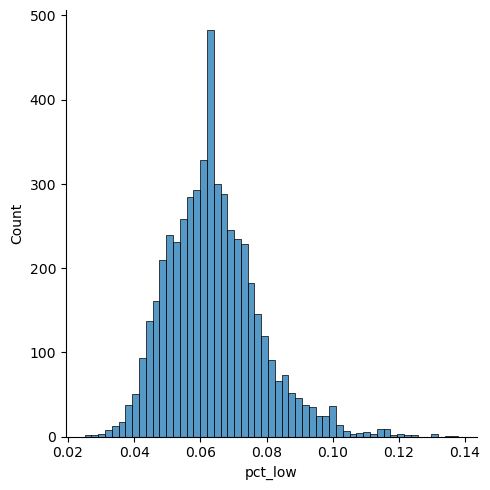

In [204]:
sns.displot(df['pct_low']);

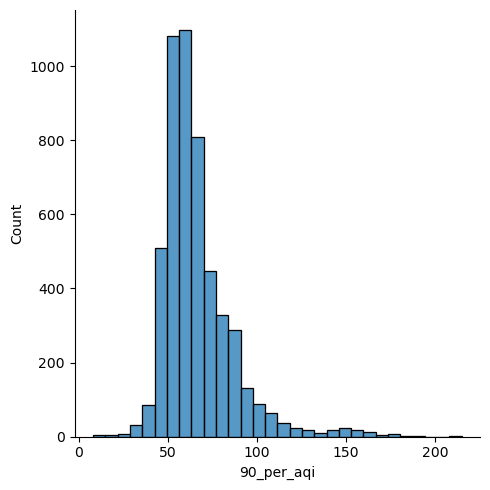

In [208]:
sns.displot(df['90_per_aqi'],
            bins=30)

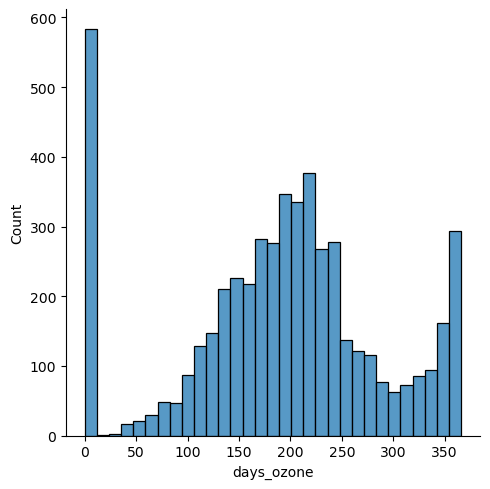

In [210]:
sns.displot(df['days_ozone'])

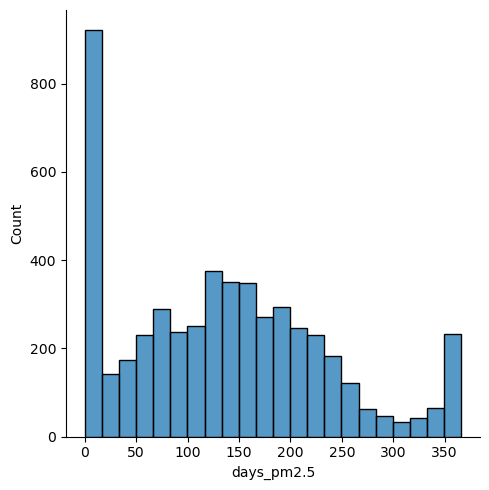

In [211]:
sns.displot(df['days_pm2.5'])

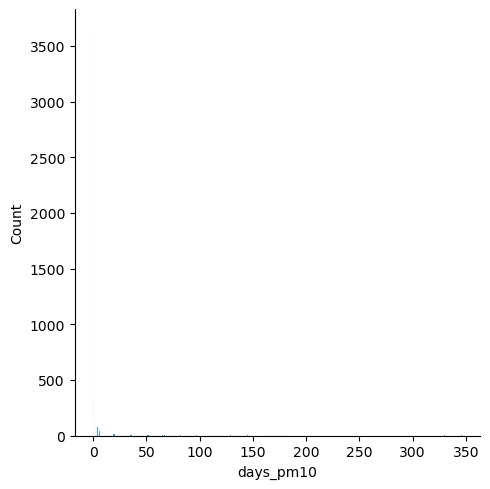

In [212]:
sns.displot(df['days_pm10'])

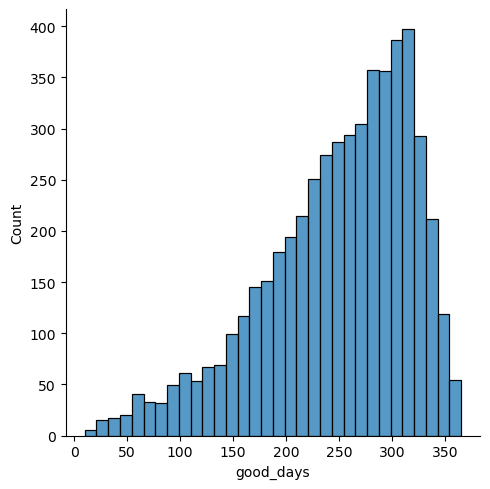

In [213]:
sns.displot(df['good_days'])

What are the state/county combos with the highest percentage of low birthweight?

In [198]:
df.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
309,Georgia,Clayton,2020,121,103,18,0,0,0,0,...,0,121,0,396.0,1977.646,35.005,2874.0,3078.496,38.191,0.138
4992,Louisiana,Caddo,2010,363,261,91,11,0,0,0,...,303,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135
1984,Mississippi,Hinds,2014,365,180,184,0,1,0,0,...,91,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131
434,Mississippi,Hinds,2020,366,249,116,1,0,0,0,...,101,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130
4706,Louisiana,Caddo,2011,365,240,107,18,0,0,0,...,297,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130
2864,Mississippi,Hinds,2017,365,256,109,0,0,0,0,...,114,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125
320,Georgia,Richmond,2020,366,268,97,1,0,0,0,...,84,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125
3855,Mississippi,Hinds,2012,366,241,122,2,1,0,0,...,117,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123
1524,Mississippi,Hinds,2019,365,256,109,0,0,0,0,...,143,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123
2403,Mississippi,Hinds,2015,365,217,148,0,0,0,0,...,110,253,0,307.0,1967.857,34.094,2566.0,3085.500,37.993,0.120


I see there are some entries here that look to have only 120 days or so of recording data (looking at the days_with_aqi).  Let's filter ones that have at least 300 so we're getting at least 10 months of data.

In [195]:
df_300 = df[df['days_with_aqi'] > 300]

In [196]:
df_300.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
4992,Louisiana,Caddo,2010,363,261,91,11,0,0,0,...,303,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135
1984,Mississippi,Hinds,2014,365,180,184,0,1,0,0,...,91,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131
434,Mississippi,Hinds,2020,366,249,116,1,0,0,0,...,101,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130
4706,Louisiana,Caddo,2011,365,240,107,18,0,0,0,...,297,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130
320,Georgia,Richmond,2020,366,268,97,1,0,0,0,...,84,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125
2864,Mississippi,Hinds,2017,365,256,109,0,0,0,0,...,114,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125
3855,Mississippi,Hinds,2012,366,241,122,2,1,0,0,...,117,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123
1524,Mississippi,Hinds,2019,365,256,109,0,0,0,0,...,143,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123
2340,Louisiana,Caddo,2015,364,303,61,0,0,0,0,...,278,86,0,303.0,1905.512,33.515,2515.0,3110.653,37.936,0.120
4386,Virginia,Hampton City,2013,359,313,44,2,0,0,0,...,165,181,0,48.0,1738.479,32.729,399.0,3205.329,38.266,0.120


What are the year/county combinations that have the smallest percentage?

In [197]:
df_300.sort_values(by='pct_low', ascending=True).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_ozone,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low
494,New York,Tompkins,2020,364,359,5,0,0,0,0,...,364,0,0,13.0,2204.077,35.077,530.0,3403.653,39.079,0.025
1584,New York,Tompkins,2019,356,349,7,0,0,0,0,...,356,0,0,14.0,2174.000,35.571,510.0,3414.189,39.043,0.027
1264,Washington,Cowlitz,2018,365,338,23,2,2,0,0,...,0,365,0,23.0,2147.913,35.304,819.0,3456.101,38.976,0.028
2142,Washington,Cowlitz,2014,323,309,14,0,0,0,0,...,0,323,0,24.0,1982.417,34.125,804.0,3443.707,39.232,0.030
1636,Oregon,Linn,2019,365,280,83,2,0,0,0,...,0,365,0,33.0,2000.636,33.939,1048.0,3498.659,39.032,0.031
671,California,Humboldt,2008,364,349,15,0,0,0,0,...,286,50,4,37.0,1884.730,33.556,1168.0,3430.532,38.935,0.032
3435,Oregon,Linn,2016,366,333,33,0,0,0,0,...,0,366,0,33.0,2068.242,34.424,1027.0,3460.391,39.009,0.032
1647,Pennsylvania,Centre,2019,365,267,98,0,0,0,0,...,203,162,0,27.0,2042.370,34.296,819.0,3428.707,39.076,0.033
3076,Wisconsin,La Crosse,2017,360,311,49,0,0,0,0,...,194,166,0,27.0,2059.185,33.889,819.0,3462.660,39.269,0.033
3443,Pennsylvania,Blair,2016,366,285,79,2,0,0,0,...,196,166,4,28.0,1989.750,34.143,846.0,3410.701,38.995,0.033


# PARKING LOT

In [542]:
# aqi['state'].unique()

In [241]:
# aqi.drop(
#     aqi[
#         aqi['state'].isin(
#             ['Country Of Mexico', 'Puerto Rico', 'Virgin Islands', 'Canada']
#         )
#     ].index, inplace=True)

In [242]:
# aqi['county'].unique()

In [541]:
# aqi.head(3)

In [540]:
# aqi.describe()

All the values seem like they would be in range--meaning no negative counts, no days over 366.

Looking at example data that Winston collected via API

In [ ]:
# df.drop_duplicates()

In [220]:
# df = pd.read_csv('data/AQS_data_test_Alabama_2006.csv')

In [539]:
# df.head()

In [543]:
# df.columns

In [544]:
# df['sample_duration_code'].unique()

In [545]:
# df[['parameter', 'sample_duration_code']].value_counts()

In [225]:
# df.drop(['Unnamed: 0', 'state_code', 'county_code'], axis=1, inplace=True)

In [226]:
# df.shape

In [227]:
# df['county'].unique()

In [228]:
# df[(df['state'] == 'Alabama') & (df['county'] == 'Shelby')]['pollutant_standard'].unique()

#### Import Data

The air quality data was downloaded from https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual as files containing annual data from years 2016-2021.  We are combining these CSV files into a single dataframe and will evaluate whether it will meet the needs for the project, or whether data will need to be collected through the API that the EPA offers for AirData.

In [229]:
# # code from Winston merged with approach from
# # https://towardsdatascience.com/pandas-concat-tricks-you-should-know-to-speed-up-your-data-analysis-cd3d4fdfe6dd

# data_path = Path('data/')

# # create a list of all the AQI csv files
# dfs = (
#     pd.read_csv(file) for file in data_path.glob('*_aqi_*') if file.is_file()
# )

# # concatenate the dataframes
# res = pd.concat(dfs)

# # export the final csv
# res.to_csv('data/aqi_by_year_2006-2021.csv', index=False)

Read the final CSV for all the AQI data

In [546]:
# aqi = pd.read_csv('data/aqi_by_year_2006-2021.csv')

#### General Look and Cleanup

In [547]:
# aqi.head()

In [548]:
# aqi.columns

In [549]:
# aqi.shape

In [550]:
# aqi.dtypes

In [551]:
# aqi.columns = [col.lower().replace(' ', '_') for col in aqi.columns]

In [552]:
# aqi.columns

#### Rename Columns
Mainly to trim the length of some of the column names to make it easier to work with.

In [554]:
# aqi.rename(columns={
#     'moderate_days': 'mod_days',
#     'unhealthy_for_sensitive_groups_days': 'uh_sens_days',
#     'unhealthy_days': 'uh_days',
#     'very_unhealthy_days': 'v_uh_days',
#     'hazardous_days': 'haz_days',
#     '90th_percentile_aqi': '90_per_aqi'
#     }, inplace=True)

In [555]:
# aqi.isnull().sum()[aqi.isnull().sum() > 0]

In [556]:
# aqi[['state', 'county']].nunique()

Since the API call failed me, I found that the annual concentration data looked fairly similar to what we were collecting, so giving that a shot.  I downloaded the annual files for years 2006-2021, so we'll take a shot at seeing if this data can be worked into a solution

In [557]:
# # code from Winston merged with approach from
# # https://towardsdatascience.com/pandas-concat-tricks-you-should-know-to-speed-up-your-data-analysis-cd3d4fdfe6dd

# data_path = Path('data/')

# # create a list of all the AQI csv files
# dfs = (
#     pd.read_csv(file, low_memory=False) for file in data_path.glob('*_conc_*') if file.is_file()
# )

# # concatenate the dataframes
# df = pd.concat(dfs)

# # export the final csv
# # res.to_csv('data/aqi_by_year_2006-2021.csv', index=False)

In [558]:
# # in the current data, I think this is akin to completeness_indicator
# df = df[df['completeness_indicator']=='Y']

In [559]:
# df['Year'].value_counts()

In [560]:
# df.columns

In [561]:
# df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [562]:
# df.columns

In [563]:
# df.isna().sum()[df.isna().sum() > 0]

In [564]:
# df['completeness_indicator'].value_counts()

In [565]:
# df.head()

In [570]:
# df.shape

In [571]:
# births = pd.read_csv('data/cdc_cleaned.csv')

In [572]:
# births.head()

In [569]:
# births.shape

In [568]:
# births.describe()

In [567]:
# births['year'].value_counts()

In [566]:
# set(births[births['year'] == 2007]['county'])

In [80]:
# how many counties from the aqi are also in the cdc data
# len(set(aqi['county']).intersection(set(cdc['County'])))

In [81]:
# what are the differences
#set(aqi['county']).difference(set(cdc['County']))

### EPA API Information

Look to see if getting more granular data from the API is feasible

Your user ID is your email address: mrhurless@gmail.com 
Your key is: rubymouse94 

In [82]:
# import requests

In [83]:
# email = 'mrhurless@gmail.com'
# key = 'rubymouse94'

# url = f'https://aqs.epa.gov/data/api/list/parametersByClass?email={email}&key={key}&pc=CRITERIA'

# res = requests.get(url)

# res.status_code

In [84]:
# # from https://stackoverflow.com/questions/71603314/ssl-error-unsafe-legacy-renegotiation-disabled

# import urllib3
# import ssl

# class CustomHttpAdapter (requests.adapters.HTTPAdapter):
#     # "Transport adapter" that allows us to use custom ssl_context.

#     def __init__(self, ssl_context=None, **kwargs):
#         self.ssl_context = ssl_context
#         super().__init__(**kwargs)

#     def init_poolmanager(self, connections, maxsize, block=False):
#         self.poolmanager = urllib3.poolmanager.PoolManager(
#             num_pools=connections, maxsize=maxsize,
#             block=block, ssl_context=self.ssl_context)


# def get_legacy_session():
#     ctx = ssl.create_default_context(ssl.Purpose.SERVER_AUTH)
#     ctx.options |= 0x4  # OP_LEGACY_SERVER_CONNECT
#     session = requests.session()
#     session.mount('https://', CustomHttpAdapter(ctx))
#     return session

In [85]:
# res = get_legacy_session().get(url)

In [573]:
# def get_aqi():
#     creds = ('mhurless@me.com', '0n3L0v3#')
#     email = 'mrhurless@gmail.com'
#     key = 'rubymouse94'
#     all_posts = []
    
#     url = "https://support.brightsign.biz/api/v2/community/posts"
    
#     res = requests.get(url, auth=creds)
    
#     # get data other than posts data
#     metadata = {
#                 key: value for key, value in res.json().items() 
#                 if key != 'posts'
#             }
    
#     last_page = metadata['page_count']
#     current_page = metadata['page']
    
#     #count = 0 #keep track of posts # don't think this is needed with this
#     # approach

#     # goal is to get posts from all pages, so we'll check if we've reached 
#     # the last page, but will also put in a catch for the rate limit as 
#     # mentioned by the API docs
    
#     while current_page <= last_page:
#         res = requests.get(url, auth=creds)

#         if res.status_code == 200:
#             posts = pd.DataFrame(res.json()['posts'])
#             metadata = {
#                 key: value for key, value in res.json().items() 
#                 if key != 'posts'
#             }
            
#             # update current page
#             current_page = metadata['page']
            
#             # update URL to pull posts from next page
#             url = metadata['next_page']

#             all_posts.append(posts)
            
#             #sleep(5)

#             if metadata['page'] == metadata['page_count']: 
#                 break #break loop if last page is reached

#             #get sequential posts from most recent to least    
#             #params['before'] = posts['created_utc'].min()
#         elif res.status_code == 429:
#             sleep(res.headers['retry-after'])
#         else:
#             print(f'status: {res.status_code}')  
#     print(f'posts retrieved from API: {len(all_posts)}')

#     return pd.concat(all_posts)